# Retrieval-Augmented Generation (RAG) für Lieferantenberichte mit LangChain – Musterlösung

Dieses Notebook zeigt eine vollständige, robuste RAG-Pipeline mit **LangChain** und OpenAI GPT – angepasst für die Lieferantenberichte.

- API-Key-Laden aus `.env`
- PDF-Pfade: `data/PDFs/`
- Exakter Systemprompt (Anweisung) an das LLM
- Visualisierung von Chunk-Längen und Retrieval-Score

---

## Ablauf
1. PDFs einlesen (`data/PDFs/`)
2. Text in Chunks teilen, analysieren & visualisieren
3. Embeddings, Vektorstore & Retriever aufbauen
4. Kette mit exaktem Systemprompt (z.B. für eine KI-Prüfung)
5. Fragen stellen, relevante Chunks und Scores visualisieren
    

In [62]:
# !pip install langchain langchain_community langchain_openai openai pypdf python-dotenv

In [63]:
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import textwrap

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
import chromadb

# API-Key aus .env laden
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Parameter für chunk-Auswahl
k = 5  # Anzahl der Top-Chunks pro Frage – anpassbar


## 1. PDF laden & Metadaten ergänzen

Wir lesen alle PDFs ein und hängen jedem Dokument den Dateinamen als Metadaten an – so behalten wir die Herkunft im Blick.


In [64]:
# PDFs laden & Metadaten
pdf_dir = "data/PDFs"
all_docs = []

for fn in os.listdir(pdf_dir):
    if not fn.endswith(".pdf"): continue
    loader = PyPDFLoader(os.path.join(pdf_dir, fn))
    docs = loader.load()
    supplier_name = fn.replace(".pdf", "")
    for d in docs:
        d.metadata["source_file"] = fn
        d.metadata["supplier"] = supplier_name
    all_docs.extend(docs)

print(f"{len(all_docs)} Seiten aus PDF-Dateien geladen.")




17 Seiten aus PDF-Dateien geladen.


## 2. Chunking mit Metadaten

Wir zerteilen die Texte in handliche Chunks (~800 Zeichen) mit 100 Zeichen Überschneidung, um gezieltes Retrieval zu ermöglichen.

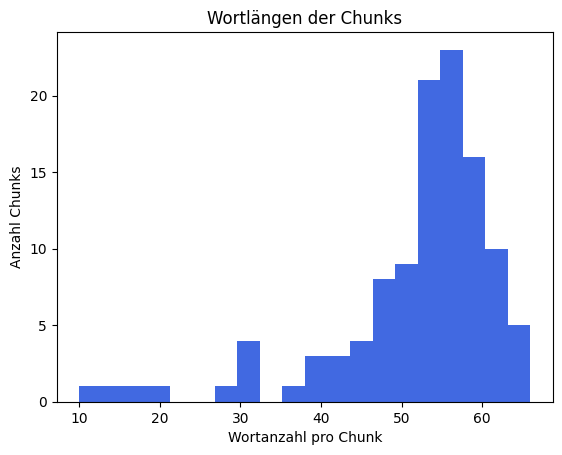

112 Chunks insgesamt.


In [65]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=0,
    separators=["\n\n", "\n", ".", "!", "?", " ", ""]
)
split_docs = text_splitter.split_documents(all_docs)

chunk_lens = [len(d.page_content.split()) for d in split_docs]
plt.hist(chunk_lens, bins=20, color='royalblue')
plt.title("Wortlängen der Chunks")
plt.xlabel("Wortanzahl pro Chunk")
plt.ylabel("Anzahl Chunks")
plt.show()

print(f"{len(split_docs)} Chunks insgesamt.")



## 3. Embeddings & Vektorstore (Chroma)

Die Chunks werden in Embeddings umgewandelt und im Vektorstore abgelegt.


In [66]:
# Vektorstore (sauber neu erstellen)
embeddings = OpenAIEmbeddings()
client = chromadb.PersistentClient(path="db/")
if "chunks" in [c.name for c in client.list_collections()]:
    client.delete_collection("chunks")

vectordb = Chroma(client=client, collection_name="chunks",
                   embedding_function=embeddings)
vectordb.add_documents(split_docs)
print("✅ Vektorstore erstellt (Duplikate gelöscht)")




✅ Vektorstore erstellt (Duplikate gelöscht)


## 4. Prompt-Template definieren

Ein allgemeines, strenges Prompt, das ausschließlich auf den Kontext zugreift und kurze, präzise Antworten lierfert.

In [67]:
# Prompt-Template
prompt = PromptTemplate(
    input_variables=["context","question"],
    template="""Du bist ein strenger KI‑Prüfer für unsere Lieferantenberichte.
Verwende ausschließlich den Kontext (Chunks).
Gib die Antwort präzise (max. 5 Sätze).
Falls du keine Antwort findest, sage "Keine Antwort gefunden".
Sei besonders vorsichtig bei Fragen zu Personen. Überprüfe die Chunks sorgfältig und nenne nur Personen, 
die im Kontext erwähnt werden. Achte darauf, dass du die Personen den Unternehmen (steht in den Metadaten vor jedem Chunk) richtig zuordnest.
Wenn die gesuchten Personen nicht im Kontext erwähnt werden, antworte dass du zu diesem Unternehmen keine Personen gefunden hast.
Gehe zur Beantwortung der Frage so vor, dass du, wenn du die Antwort nicht findest, 
die Chunks nochmal sorgfältig durchliest und die Antwort dann gibst.


Kontext:
{context}

Frage: {question}
Antwort:"""
)

## 6. Retriever‑ und LLM‑Chain aufsetzen

Wir nutzen GPT-3.5 Turbo für das RetrievalQA‑Setup. k ist flexible einstellbar.

In [68]:
# RetrievalQA Chain
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
retriever = vectordb.as_retriever(search_kwargs={"k": k})
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, retriever=retriever,
    chain_type="stuff",  # aktuell empfohlen
    chain_type_kwargs={"prompt": prompt},
    return_source_documents=True
)



## 7. Fragen beantworten & Top‑Chunks anzeigen

Wir iterieren über deine 6 Fragen, geben die Antwort aus und zeigen die 3 relevantesten Chunks mit Herkunft.


In [69]:
# Fragen stellen & Ausgaben
fragen = [
    "Welche Lieferanten für Halbzeuge haben wir?",
    "Welche Lieferanten für Präzisionszylinder haben wir aktuell?",
    "Welche Probleme treten bei der Zylinder AG auf?",
    "Wieso beliefert uns die Präzisions GmbH aktuell nicht?",
    "Wer ist unser/e Ansprechpartner/in bei der Sparfuchs GmbH und wer bei der Qualitätsfuchs GmbH?",
    "Welchen groeßen Vorteil bietet die Sparfuchs GmbH gegenüber der Qualitätsfuchs GmbH?",
    "Wurde die Präzisions GmbH wegen schlechter Qualität oder wegen zu hoher Preise nicht als Hauptlieferant ausgewählt?"
]



for i, frage in enumerate(fragen):
    print("\n" + "="*80)
    print(f"Frage {i+1}: {frage}")
    result = qa_chain({"query": frage})
    print("\nAntwort:", result["result"])
    print(f"\nTop relevante Chunks:")
    for idx, doc in enumerate(result["source_documents"][:1]):
        sup = doc.metadata.get("supplier", "unbekannt")
        src = doc.metadata.get("source_file", "unbekannt")
        print(f"[{idx+1}] {sup} ({src}):")
        print(textwrap.shorten(doc.page_content, width=300, placeholder="..."))




Frage 1: Welche Lieferanten für Halbzeuge haben wir?

Antwort: Die Lieferanten für Halbzeuge sind die Qualitätsfuchs GmbH und die Sparfuchs GmbH.

Top relevante Chunks:
[1] Qualitätsfuchs GmbH (Qualitätsfuchs GmbH.pdf):
haben ihren Preis – einen Preis, den man durchaus spürt, wenn man die Rechnungen am Monatsende gegenüberstellt. Die Qualitätsfuchs GmbH hat sich auf die Belieferung von Industrieunternehmen mit hochwertigen Halbzeugen spezialisiert. Ob Bleche, Rohre, Stangen, Profile oder Sonderformen – das...

Frage 2: Welche Lieferanten für Präzisionszylinder haben wir aktuell?

Antwort: Aktuell haben wir die Zylinder AG als Hauptlieferanten für hochpräzise Zylinder. Zudem wird die Präzisions GmbH erneut als Lieferantenkandidat in Betracht gezogen, da die Qualität der Zylinder AG sich verschlechtert hat.

Top relevante Chunks:
[1] Präzisions AG (Präzisions AG.pdf):
In den letzten Monaten wurde in unserem Hause vermehrt diskutiert, ob es sinnvoll wäre, die Präzisions GmbH erneut als L